## todo 
+ spectral gain functions

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import os
import pyworld
import librosa
import time
import matplotlib.pyplot as plt

from preprocess import *
from model import *

torch.manual_seed(0)
np.random.seed(0)

In [2]:
model_dir = "./model/model_mc32_fr1024"
model_name = "model_mc32_fr1024"

data_dir = "./data/voice_data"
# voice_dir = ["F4", "F5", "F6", "M2"]
voice_dir = ["test01", "test02"]

# _from = voice_dir.index("test01")
# _to = voice_dir.index("test02")
_from = voice_dir.index("M2")
_to = voice_dir.index("F4")

# output_dir = "./converted_voices/model_mc32_fr1024_training_progress"
output_dir = "./converted_voices/test"

# figure_dir = "./figure/model_mc32_fr1024"
figure_dir = "./figure/test"

In [3]:
if (False):
    for v in voice_dir:
        print("Preprocess: " + v)
        preprocess_voice(os.path.join(data_dir, v), v)

In [4]:
num_epochs = 10 #10000
batch_size = 4
learning_rate =1e-3
learning_rate_ = 1e-4
learning_rate__ = 1e-5
learning_rate___ = 1e-6
sampling_rate = 16000
num_envelope  = 36
num_mcep = 36
frame_period = 5.0
n_frames = 1024 

losses = []
loss_num = 0

In [5]:
def model_save(model, model_dir, model_name):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(model.state_dict(), os.path.join(model_dir, model_name))
    
def model_load(model_dir, model_name):
    model = ACVAE()
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))

In [6]:
def save_figure(losses, epoch):        
    if not os.path.exists(figure_dir):
            os.makedirs(figure_dir)
    losses = np.array(losses)
    losses = losses.reshape(-1, 4)
    x = np.linspace(0, len(losses), len(losses))
    losses_label = ("L1", "KLD", "AC_p", "AC_s")
    plt.figure()
    plt.plot(x, losses[:,0], label=losses_label[0])
    plt.plot(x, losses[:,1], label=losses_label[1])
    plt.plot(x, losses[:,2], label=losses_label[2])
    plt.plot(x, losses[:,3], label=losses_label[3])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)
    plt.savefig(figure_dir + "/" + "epoch_{:05}".format(epoch) + ".png")
        
    plt.figure()
    plt.plot(x, losses[:,2], label=losses_label[2])
    plt.plot(x, losses[:,3], label=losses_label[3])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)
    plt.savefig(figure_dir + "/" + "epoch_{:05}_AC".format(epoch) + ".png")
    
    plt.figure()
    plt.plot(x, losses[:,0], label=losses_label[0])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)
    plt.savefig(figure_dir + "/" + "epoch_{:05}_L1".format(epoch) + ".png")
    
    plt.figure()
    plt.plot(x, losses[:,1], label=losses_label[1])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)
    plt.savefig(figure_dir + "/" + "epoch_{:05}_KLD".format(epoch) + ".png")

In [7]:
def data_load(batchsize = 1, s = -1, t = -1):
    x = []
    label = []
    for i in range(batchsize):
        if (s == -1):
            label_num = np.random.randint(len(voice_dir))
        else:
            label_num = s
        voice_path = os.path.join(data_dir, voice_dir[label_num])
        files = os.listdir(voice_path)
        
        frames = 0
        while frames < n_frames:
            
            file = ""
            while file.count("wav") == 0 or file.count("normal") == 0:
                file = np.random.choice(files)
            wav, _ = librosa.load(os.path.join(voice_path, file), sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period, num_mcep = num_mcep)
            # coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_envelope)
            
            # coded_sp_transposed = coded_sp.T
            mc_transposed  = np.array(mc).T
            # frames = np.shape(coded_sp_transposed)[1]
            frames = np.shape(mc_transposed)[1]
            
        mcep_normalization_params = np.load(os.path.join(voice_path, "mcep_"+voice_dir[label_num]+".npz"))
        mcep_mean = mcep_normalization_params['mean']
        mcep_std = mcep_normalization_params['std']
        mc_norm = (mc_transposed  - mcep_mean) / mcep_std
            
        start_ = np.random.randint(frames - n_frames + 1)
        end_ = start_ + n_frames
            
        # x.append(coded_sp_norm[:,start_:end_])
        x.append(mc_norm[:,start_:end_])
        label.append(label_num)

    return torch.Tensor(x).view(batchsize, 1, num_mcep, n_frames), torch.Tensor(label)

In [14]:
def test_one_file(model, s_label, t_label, epoch):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    voice_path_s = os.path.join(data_dir, voice_dir[s_label])
    voice_path_t = os.path.join(data_dir, voice_dir[t_label])
    
    files = os.listdir(voice_path_s)
    file = ""
    while file.count("wav") == 0 or file.count("normal") == 0:
        file = np.random.choice(files)
        
    wav, _ = librosa.load(os.path.join(voice_path_s, file), sr = sampling_rate, mono = True)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap, mc = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
    #coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
    
    # coded_sp_transposed = coded_sp.T
    mc_transposed  = np.array(mc).T
    
    mcep_normalization_params_s = np.load(os.path.join(voice_path_s, "mcep_"+voice_dir[s_label]+".npz"))
    mcep_mean_s = mcep_normalization_params_s['mean']
    mcep_std_s = mcep_normalization_params_s['std']    
    mcep_normalization_params_t = np.load(os.path.join(voice_path_t, "mcep_"+voice_dir[t_label]+".npz"))
    mcep_mean_t = mcep_normalization_params_t['mean']
    mcep_std_t = mcep_normalization_params_t['std']
    
    #coded_sp_norm = (coded_sp_transposed - mcep_mean_s) / mcep_std_s
    mc_norm = (mc_transposed - mcep_mean_s) / mcep_std_s
    
    # x = torch.Tensor(coded_sp_norm).view(1, 1, coded_sp_norm.shape[0], coded_sp_norm.shape[1])
    x = torch.Tensor(mc_norm).view(1, 1, mc_norm.shape[0], mc_norm.shape[1])
    
    label_s_tensor = torch.Tensor(np.array([s_label])).view(1, 1)
    label_t_tensor = torch.Tensor(np.array([t_label])).view(1, 1)
    
    x = x.to(device)
    label_s_tensor = label_s_tensor.to(device)
    label_t_tensor = label_t_tensor.to(device)
    
    mu_enc, logvar_enc = model.encode(x, label_s_tensor)
    z_enc = model.reparameterize(mu_enc, logvar_enc)
    # x^
    mu_dec_t, logvar_dec_t = model.decode(z_enc, label_t_tensor)
    z_dec_t = model.reparameterize(mu_dec_t, logvar_dec_t)
    if (torch.cuda.is_available()):
        z_dec_t = z_dec_t.data.cpu().numpy().reshape((mc_norm.shape[0], mc_norm.shape[1]))
    else:
        z_dec_t = z_dec_t.data.numpy().reshape((mc_norm.shape[0], mc_norm.shape[1]))
    # x_
    mu_dec_s, logvar_dec_s = model.decode(z_enc, label_s_tensor)
    z_dec_s = model.reparameterize(mu_dec_s, logvar_dec_s)
    if (torch.cuda.is_available()):
        z_dec_s = z_dec_s.data.cpu().numpy().reshape((mc_norm.shape[0], mc_norm.shape[1]))
    else:
        z_dec_s = z_dec_s.data.numpy().reshape((mc_norm.shape[0], mc_norm.shape[1]))
    
    mc_converted_t = z_dec_t * mcep_std_t + mcep_mean_t
    mc_converted_t = mc_converted_t.T
    mc_converted_t = np.ascontiguousarray(mc_converted_t)
    sp_converted_t = world_decode_mc(mc = mc_converted_t, fs = sampling_rate)
    mc_converted_s = z_dec_s * mcep_std_s + mcep_mean_s
    mc_converted_s = mc_converted_s.T
    mc_converted_s = np.ascontiguousarray(mc_converted_s)
    sp_converted_s = world_decode_mc(mc = mc_converted_s, fs = sampling_rate)
    
    sp_gained = np.multiply(sp, np.divide(sp_converted_t, sp_converted_s))
    
    logf0s_normalization_params_s = np.load(os.path.join(voice_path_s, "log_f0_"+voice_dir[s_label]+".npz"))
    logf0s_mean_s = logf0s_normalization_params_s['mean']
    logf0s_std_s = logf0s_normalization_params_s['std']
    logf0s_normalization_params_t = np.load(os.path.join(voice_path_t, "log_f0_"+voice_dir[t_label]+".npz"))
    logf0s_mean_t = logf0s_normalization_params_t['mean']
    logf0s_std_t = logf0s_normalization_params_t['std']
    
    f0_converted = pitch_conversion(f0 = f0, mean_log_src = logf0s_mean_s, std_log_src = logf0s_std_s, mean_log_target = logf0s_mean_t, std_log_target = logf0s_std_t)
    
    wav_transformed = world_speech_synthesis(f0 = f0_converted, sp = sp_gained, ap = ap, fs = sampling_rate, frame_period = frame_period)
    librosa.output.write_wav(os.path.join(output_dir, "epoch_{:05}_conv_target_f0_".format(epoch) + "_" + os.path.basename(file)), wav_transformed, sampling_rate)
    wav_source = world_speech_synthesis(f0 = f0, sp = sp_gained, ap = ap, fs = sampling_rate, frame_period = frame_period)
    librosa.output.write_wav(os.path.join(output_dir, "epoch_{:05}_conv_origin_f0_".format(epoch) + "_" + os.path.basename(file)), wav_source, sampling_rate)
    wav_source = world_speech_synthesis(f0 = (f0+f0_converted)/2.0, sp = sp_gained, ap = ap, fs = sampling_rate, frame_period = frame_period)
    librosa.output.write_wav(os.path.join(output_dir, "epoch_{:05}_conv_ave_f0_".format(epoch) + "_" + os.path.basename(file)), wav_source, sampling_rate)
    
    wav_source = world_speech_synthesis(f0 = f0_converted, sp = sp, ap = ap, fs = sampling_rate, frame_period = frame_period)
    librosa.output.write_wav(os.path.join(output_dir, "epoch_{:05}_nonconv_target_f0_".format(epoch) + "_" + os.path.basename(file)), wav_source, sampling_rate)
    
    print("Test")
    print("Source File:" + file)
    print("Converted: " + voice_dir[s_label] + " -> " + voice_dir[t_label])

cpu
Epoch: 1
Time Elapsed for one epoch: 00:00:10
Epoch: 2
Time Elapsed for one epoch: 00:00:10
Epoch: 3
Time Elapsed for one epoch: 00:00:10
Epoch: 4
Time Elapsed for one epoch: 00:00:10
Epoch: 5
Time Elapsed for one epoch: 00:00:10
Epoch: 6
Time Elapsed for one epoch: 00:00:10
Epoch: 7
Time Elapsed for one epoch: 00:00:10
Epoch: 8
Time Elapsed for one epoch: 00:00:10
Epoch: 9
Time Elapsed for one epoch: 00:00:10
Epoch: 10
Time Elapsed for one epoch: 00:00:10


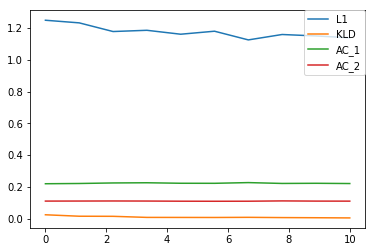

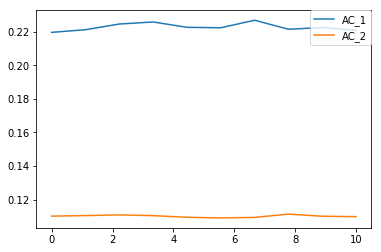

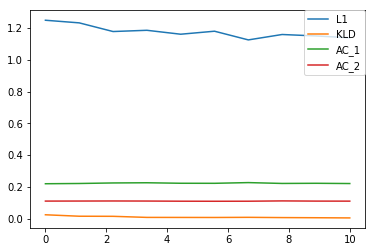

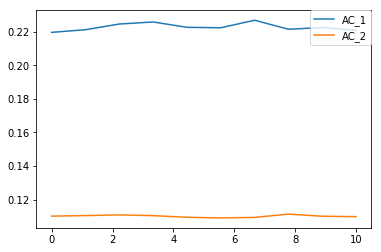

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ACVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()

for epoch in range(num_epochs):
    epoch += 1
    
    if (epoch == 2000):
        learning_rate = learning_rate_   
    if (epoch == 4000):
        learning_rate = learning_rate__
    if (epoch == 6000):
        learning_rate = learning_rate___
    
    start_time = time.time()

    print('Epoch: %d' % epoch)

    x_, label_ = data_load(batch_size)
    optimizer.zero_grad()
    loss, loss_list = model.calc_loss(x_, label_)
    loss.backward()
    losses.append(loss_list)
    optimizer.step()
    loss_num += 1
    
    if epoch % 50 == 0:
        test_one_file(model, _from, _to, epoch)
        test_one_file(model, voice_dir.index("F5"), _to, epoch)
    if epoch % 100 == 0:
        model_save(model, model_dir, model_name)
    if epoch % 2000 == 0:
        model_save(model, model_dir, model_name + "_" + str(epoch))

    if epoch % 10 == 0:
        save_figure(losses, epoch)
    
    elapsed_time = time.time() - start_time
    print('Time Elapsed for one epoch: %02d:%02d:%02d' % (elapsed_time // 3600, (elapsed_time % 3600 // 60), (elapsed_time % 60 // 1)))

model_save(model, model_dir, model_name)

save_figure(losses, epoch)


In [10]:
a, b= data_load(2)

In [11]:
np.shape(a)

torch.Size([2, 1, 36, 1024])

(array([   37.,   286.,  1778.,  5549., 10000., 11238.,  6041.,  1632.,
          271.,    32.]),
 array([-4.04924917, -3.2436203 , -2.43799143, -1.63236256, -0.82673368,
        -0.02110481,  0.78452406,  1.59015293,  2.3957818 ,  3.20141068,
         4.00703955]),
 <a list of 10 Patch objects>)

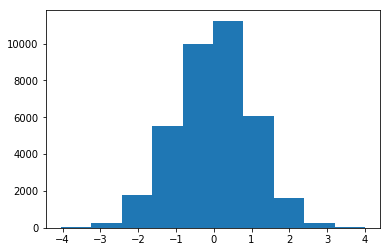

In [12]:
plt.hist(np.array(a[0,0].flatten()))

In [15]:
test_one_file(model, _from, _to, 0)

Test
Source File:tsuchiya_normal_001.wav
Converted: test01 -> test02


/Users/aoi/Workspace/Python/ACVAE-VC/preprocess.py:187: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)
